# Lab 5: Regression and Dimensionality Reduction

In [71]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## EDA

In [72]:
df = pd.read_csv("./insurance.csv")
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [73]:
df.tail()

,age,gender,bmi,children,smoker,region,insurance_cost
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240
1337,64,male,23.760,0,yes,southeast,26926.51440


In [74]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [75]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [76]:
df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


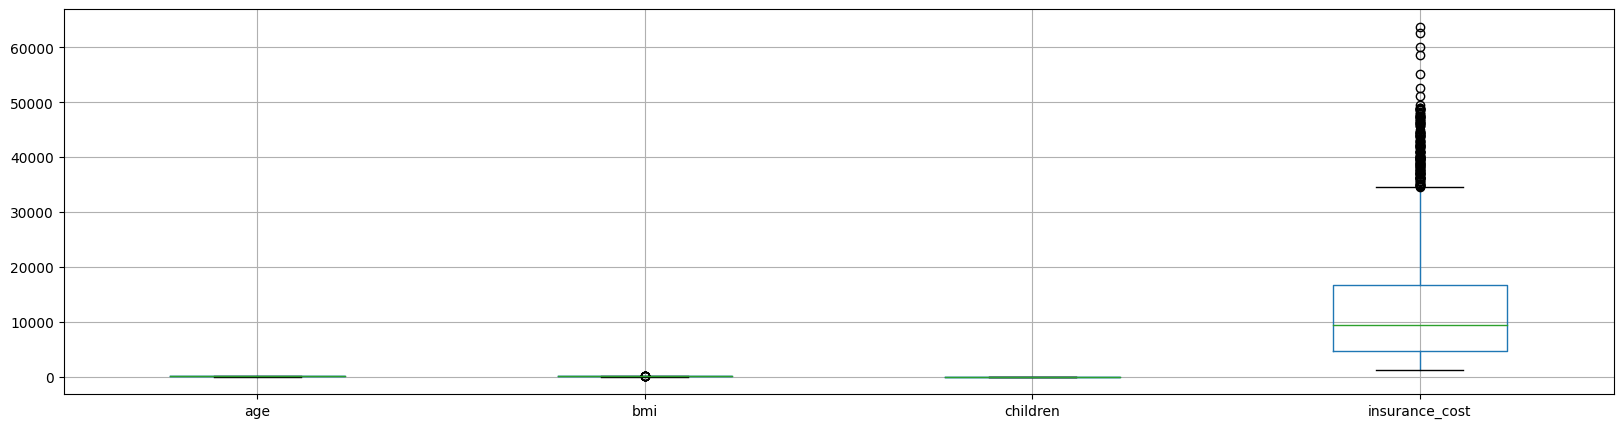

In [77]:
df.boxplot(figsize=(20,5))
plt.show()

## Data Preparation

In [78]:
df = pd.get_dummies(df,drop_first=True)

In [79]:
df.head()

,age,bmi,children,insurance_cost,gender_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,18,33.770,1,1725.55230,1,0,0,1,0
1,18,34.100,0,1137.01100,1,0,0,1,0
2,18,26.315,0,2198.18985,0,0,0,0,0
3,18,38.665,2,3393.35635,0,0,0,0,0
4,18,35.625,0,2211.13075,0,0,0,0,0


In [80]:
# robust_scaler = RobustScaler()
# df[['insurance_cost']] = robust_scaler.fit_transform(df[['insurance_cost']])

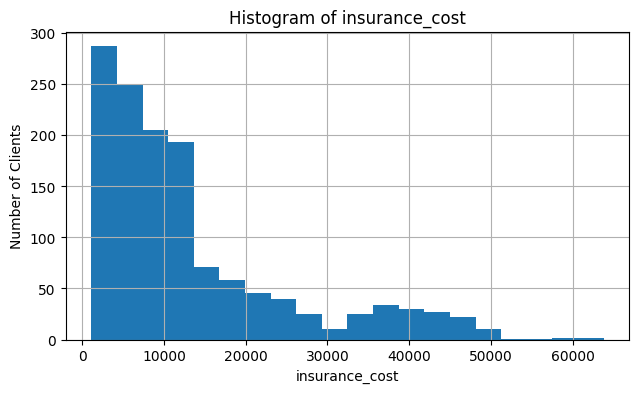

In [81]:
fig = plt.figure(figsize=(16,4))

# Plot ApplicantIncome
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Histogram of insurance_cost")
ax1.set_xlabel('insurance_cost')
ax1.set_ylabel('Number of Clients')
df['insurance_cost'].hist(bins=20)
plt.show()

In [82]:
df['insurance_cost'] = np.log(df['insurance_cost'] + abs(min(df['insurance_cost'])) + 1)

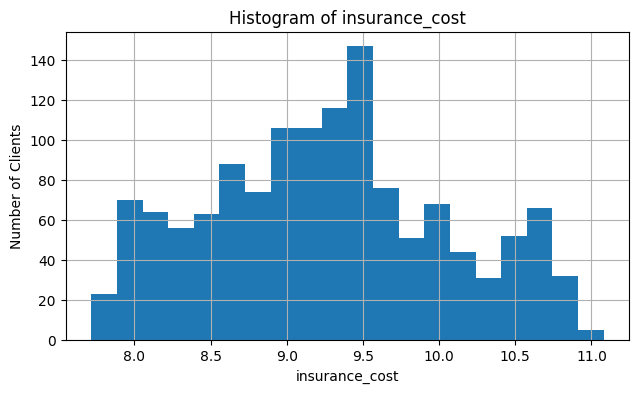

In [83]:
fig = plt.figure(figsize=(16,4))

# Plot ApplicantIncome
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Histogram of insurance_cost")
ax1.set_xlabel('insurance_cost')
ax1.set_ylabel('Number of Clients')
df['insurance_cost'].hist(bins=20)
plt.show()

In [84]:
df['children'] = df['children']/3

In [85]:
df.head()

,age,bmi,children,insurance_cost,gender_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,18,33.770,0.333333,7.954522,1,0,0,1,0
1,18,34.100,0.000000,7.723069,1,0,0,1,0
2,18,26.315,0.000000,8.108040,0,0,0,0,0
3,18,38.665,0.666667,8.415433,0,0,0,0,0
4,18,35.625,0.000000,8.111929,0,0,0,0,0


In [86]:
preprocess_pipeline = make_pipeline(StandardScaler())

In [87]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Grid Search for Best Parameters and Best Dimensionality Reduction Method

### Random Forest Pipeline

In [88]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In [89]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.828:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__max_depth': 4}


c:\Users\lakei\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lakei\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lakei\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\lakei\AppData\Local\Programs\Python\Python310\lib\site-packages\skl

### Linear Regression Pipeline

In [90]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [91]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        # 'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        # 'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.770:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6}


c:\Users\lakei\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lakei\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lakei\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\lakei\AppData\Local\Programs\Python\Python310\lib\site-packages\sklear

## Compare Regression Models on Test Set

In [92]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [93]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)

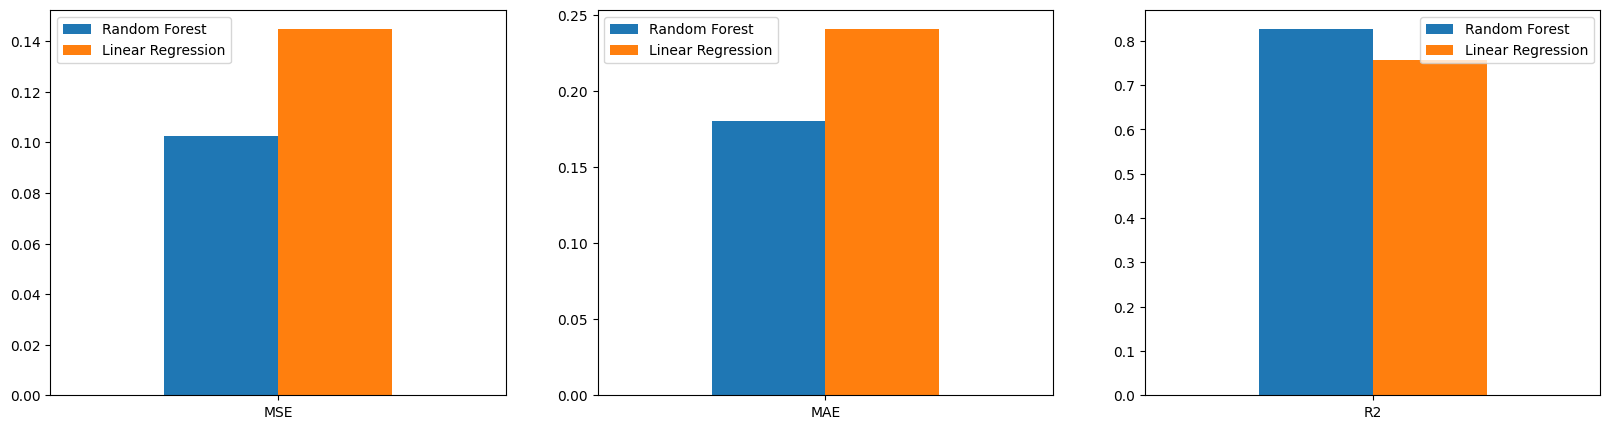

In [94]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

## Train a Final Model

In [97]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     LR_best_params.get('reduce_dim'),
                     LinearRegression(n_estimators=10, **transform(LR_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

TypeError: LinearRegression.__init__() got an unexpected keyword argument 'n_estimators'